# Machine Learning Project - TRANCOS Dataset 

## Bounding Box and Deep Learning Approch 

> By - Ishita Gupta, Rugved Chavan & Sree Deeksha Bethapuri

### Data Pre-processing

In [156]:
import os
import cv2
import numpy as np
import scipy.io as sio

# Define paths
dataset_path = 'C:/Users/Rugved Chavan/Desktop/UVA-Course/machine learning/dataset/TRANCOS_v3'
images_path = os.path.join(dataset_path, 'images')
image_sets_path = os.path.join(dataset_path, 'image_sets')

# Load image sets
def load_image_sets(set_name):
    set_path = os.path.join(image_sets_path, f'{set_name}.txt')
    image_names = []
    with open(set_path, 'r') as file:
        for line in file:
            # Strip the newline character and then remove the .jpg extension if present
            image_name = line.strip()
            if image_name.lower().endswith('.jpg'):
                image_name = image_name[:-4]  # Remove the last 4 characters, i.e., '.jpg'
            image_names.append(image_name)
    return image_names

# Reload image sets with corrected names
training_images = load_image_sets('training')
validation_images = load_image_sets('validation')
trainval_images = load_image_sets('trainval')
test_images = load_image_sets('test')

# dataset\TRANCOS_v3\image_sets\training.txt
# C:/Users/Rugved Chavan/Desktop/UVA-Course/machine learning/dataset/TRANCOS_v3/image_sets


In [157]:
len(training_images) + len(validation_images) + len(test_images) 

1244

### Data Cleaning

In [158]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Parameters
img_width, img_height = 224, 224  # Resize parameters, adjust as needed

# Initialize the data generator with some data augmentation options
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,  # Data augmentation: rotation
    width_shift_range=0.2,  # Data augmentation: horizontal shift
    height_shift_range=0.2,  # Data augmentation: vertical shift
    horizontal_flip=True,  # Data augmentation: flip horizontally
    fill_mode='nearest'
)

# Function to preprocess an image
# Modified preprocess_image function with error handling
def preprocess_image(image_path, mask_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, False

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None, False

    image = cv2.resize(image, (img_width, img_height))

    if not os.path.exists(mask_path):
        print(f"Mask not found: {mask_path}")
        return image, True  # Proceed without mask if mask is missing

    mat = sio.loadmat(mask_path)
    mask = mat['BW']  # Directly use the 'BW' key to access the mask
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
    mask = mask.astype(bool)
    image[mask == False] = 0  # Apply mask

    return image, True

# Modified load_dataset_images function to handle errors gracefully
def load_dataset_images(image_names):
    images = []
    labels = []

    for image_name in image_names:
        image_path = os.path.join(images_path, f'{image_name}.jpg')
        annotations_path = os.path.join(images_path, f'{image_name}.txt')
        mask_path = os.path.join(images_path, f'{image_name}mask.mat')

        image, success = preprocess_image(image_path, mask_path)
        if not success:
            continue  # Skip this image and proceed to the next one

        images.append(img_to_array(image))  # Convert to array suitable for model

        # Count vehicles as label
        with open(annotations_path, 'r') as file:
            annotations = file.readlines()
            labels.append(len(annotations))  # Number of vehicles

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load training and validation images and labels
train_images, train_labels = load_dataset_images(training_images)
val_images, val_labels = load_dataset_images(validation_images)

# Note: Here, we directly load images into memory. For large datasets, consider using a generator.

# Example usage with a model (assuming you have a model defined)
# model.fit(datagen.flow(train_images, train_labels, batch_size=32),
#           validation_data=(val_images, val_labels),
#           steps_per_epoch=len(train_images) // 32, epochs=10)


### Validated the the data is process properly or not

In [36]:
for i in range(5):  # Adjust the range as needed to check more or fewer samples
    image, label = train_images[i], train_labels[i]
    print(f"Image {i} shape: {image.shape}, Number of vehicles: {label}")

Image 0 shape: (224, 224, 3), Number of vehicles: 36
Image 1 shape: (224, 224, 3), Number of vehicles: 32
Image 2 shape: (224, 224, 3), Number of vehicles: 26
Image 3 shape: (224, 224, 3), Number of vehicles: 29
Image 4 shape: (224, 224, 3), Number of vehicles: 33


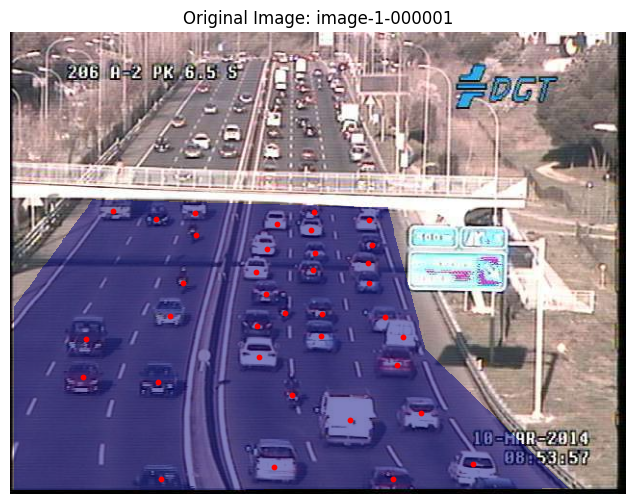

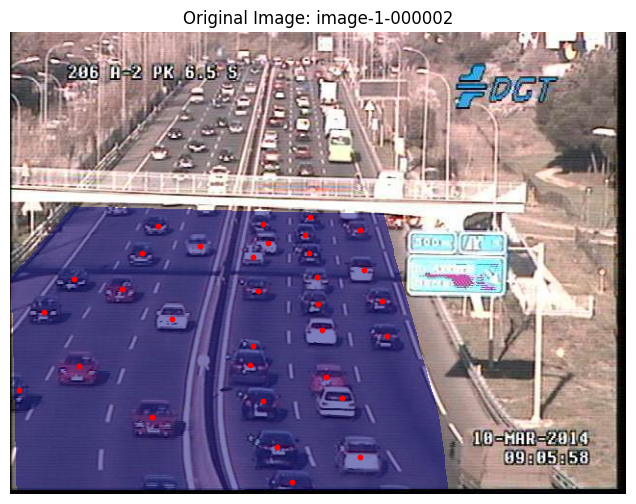

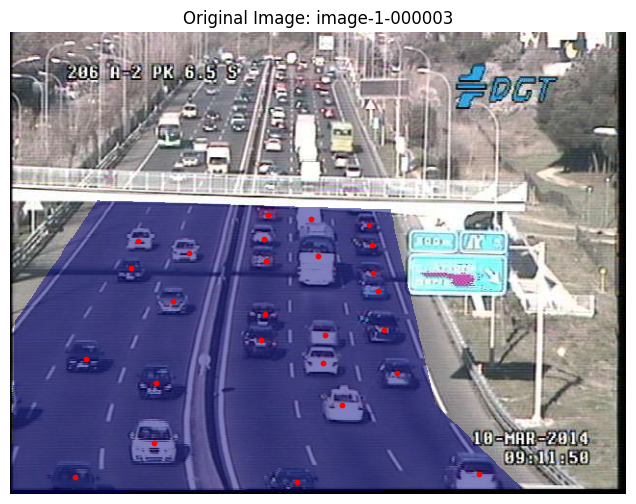

In [41]:
def visualize_data_original(image_names, images_path, annotations_path, num_samples=5):
    for i in range(num_samples):
        image_name = image_names[i]

        # Path to the original image
        original_image_path = os.path.join(images_path, f'{image_name}.jpg')

        # Load the original image
        original_image = cv2.imread(original_image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Read the original mask for visualization
        mask_path = os.path.join(images_path, f'{image_name}mask.mat')
        mat = sio.loadmat(mask_path)
        mask = mat['BW']
        mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Read annotations
        annotations_file_path = os.path.join(annotations_path, f'{image_name}.txt')
        with open(annotations_file_path, 'r') as f:
            annotations = [list(map(int, line.split())) for line in f]

        # Display the original image
        plt.figure(figsize=(10, 6))
        plt.imshow(original_image)

        # Overlay annotations
        for x, y in annotations:
            plt.scatter(x, y, c='red', s=10)  # s is the size of the point

        # Optionally overlay the mask
        mask_overlay = np.ma.masked_where(mask == 0, mask)
        plt.imshow(mask_overlay, cmap='jet', alpha=0.5)  # Adjust alpha for mask transparency

        plt.title(f'Original Image: {image_name}')
        plt.axis('off')
        plt.show()

# Adjust paths as necessary
annotations_path = images_path  # Assuming annotations are stored in the same path as images
visualize_data_original(training_images, images_path, annotations_path, num_samples=3)


# Bounding Box Approach

## Deep Learning Approch

In [42]:
# Classical CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    model = Sequential([
        # Convolutional layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Convolutional layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Convolutional layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flattening the 3D output to 1D
        Flatten(),
        
        # Dense layer for prediction
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Output layer: predicting a single value (the count of cars)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Assuming your preprocessed images are resized to 224x224 pixels
input_shape = (224, 224, 3)  # 3 channels for RGB images
model = create_cnn_model(input_shape)

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

### Pre-tranined VGG16 Model

In [72]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape):
    # Load the VGG16 model, pre-trained on ImageNet, without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Create custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)  # Output layer: predicting a single value (the count of cars)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    return model

# Assuming your preprocessed images are resized to 224x224 pixels
input_shape = (224, 224, 3)  # 3 channels for RGB images
model = create_vgg16_model(input_shape)

print(model.summary())


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [151]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape):
    # Load the VGG16 model, pre-trained on ImageNet, without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Optionally, unfreeze some of the last layers of the base model
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Create custom layers on top of the base model
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='relu')(x)  # Ensure non-negative output

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    return model

# Assuming your preprocessed images are resized to 224x224 pixels
input_shape = (224, 224, 3)  # 3 channels for RGB images
model = create_vgg16_model(input_shape)

print(model.summary())


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

### Model Training 

In [152]:
# Convert images from lists to numpy arrays if not already done
train_images_np = np.array(train_images)
train_labels_np = np.array(train_labels).astype(float)  # Ensure labels are float for regression
val_images_np = np.array(val_images)
val_labels_np = np.array(val_labels).astype(float)

# Fit the model
history = model.fit(train_images_np, train_labels_np,
                    validation_data=(val_images_np, val_labels_np),
                    epochs=50,  # Adjust the number of epochs based on your dataset size and training goal
                    batch_size=32)  # Adjust batch size based on your computational resources


Epoch 1/50
13/13 [==============================] - 3s 191ms/step - loss: 1009.7455 - mae: 28.3112 - val_loss: 222.7686 - val_mae: 11.5872
Epoch 2/50
13/13 [==============================] - 2s 168ms/step - loss: 303.5230 - mae: 13.4582 - val_loss: 3150.9434 - val_mae: 52.2079
Epoch 3/50
13/13 [==============================] - 2s 167ms/step - loss: 126.8910 - mae: 8.6585 - val_loss: 1081.5034 - val_mae: 29.6295
Epoch 4/50
13/13 [==============================] - 2s 164ms/step - loss: 98.9686 - mae: 7.4297 - val_loss: 394.4668 - val_mae: 17.2242
Epoch 5/50
13/13 [==============================] - 2s 166ms/step - loss: 79.6771 - mae: 6.8269 - val_loss: 768.2550 - val_mae: 25.2250
Epoch 6/50
13/13 [==============================] - 2s 164ms/step - loss: 77.5901 - mae: 6.3775 - val_loss: 301.7182 - val_mae: 15.2150
Epoch 7/50
13/13 [==============================] - 2s 163ms/step - loss: 66.9100 - mae: 6.1528 - val_loss: 161.3350 - val_mae: 10.8379
Epoch 8/50
13/13 [======================

## Model Evaluation

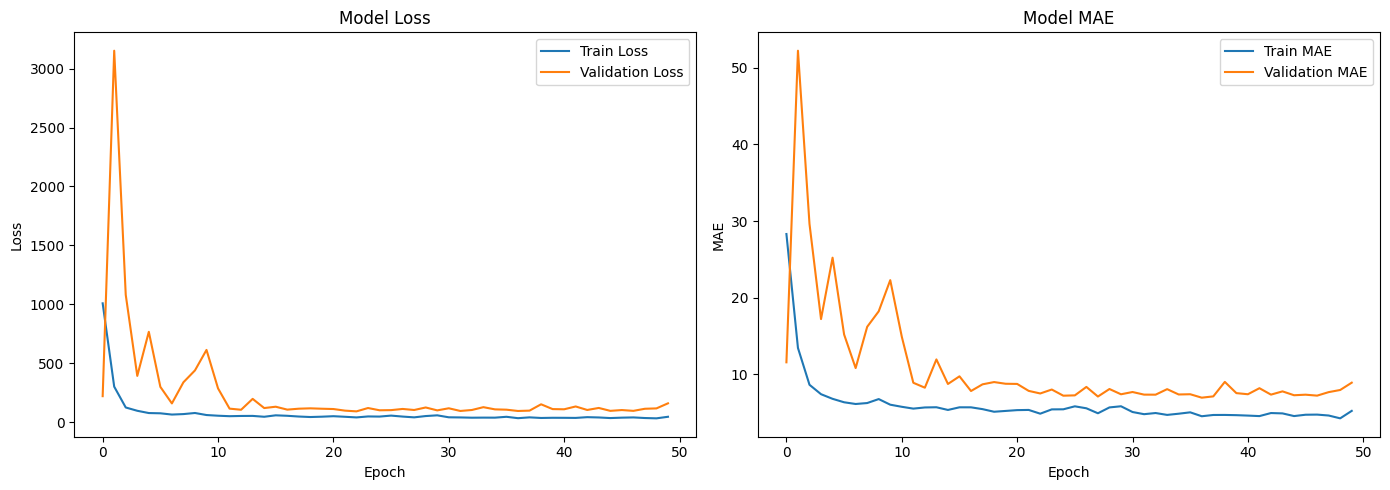

In [153]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Evaluate model on Testing data

14/14 [==============================] - 1s 63ms/step - loss: 121.1611 - mae: 7.8346
Test Loss: 121.16111755371094, Test MAE: 7.834606170654297


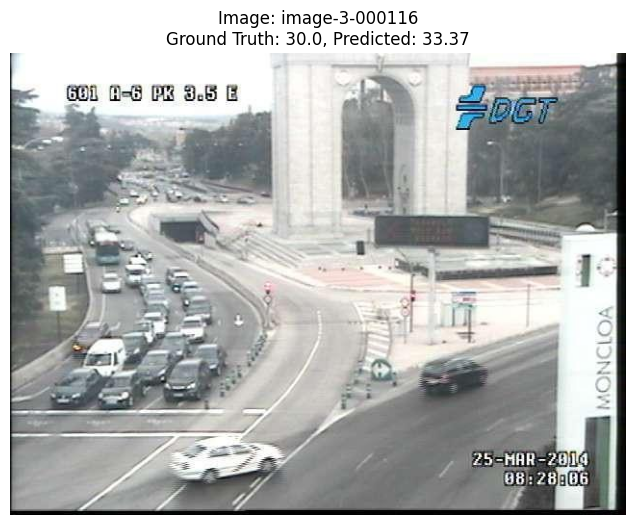

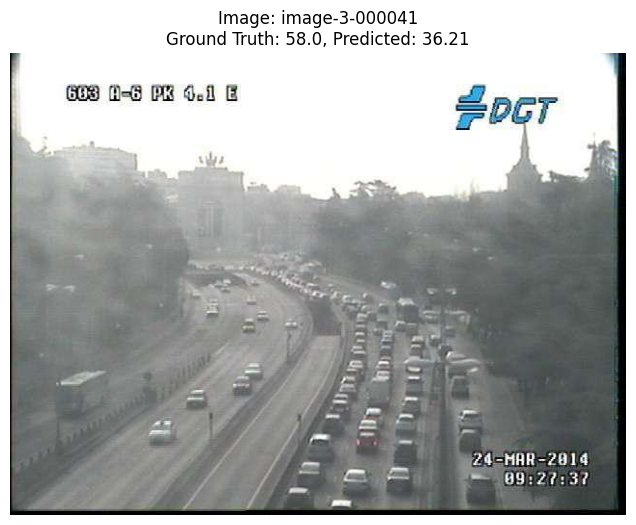

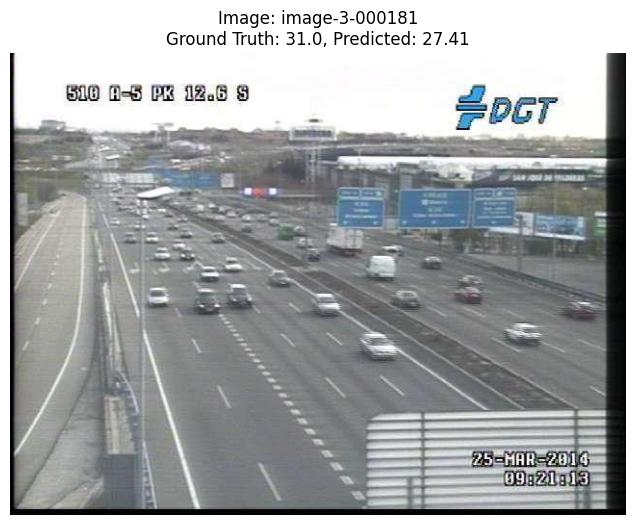

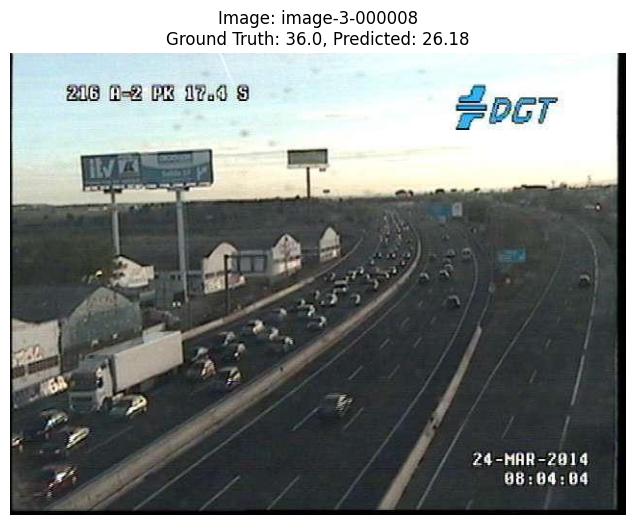

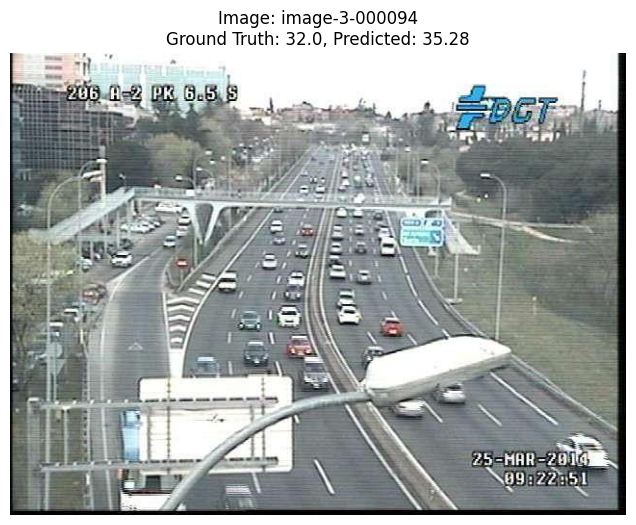

In [159]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Convert test images to numpy array if not already done
test_images_np, test_labels = load_dataset_images(test_images)
test_labels_np = np.array(test_labels).astype(float) # Ensure labels are float for regression

# Make predictions
predictions = model.predict(test_images_np).flatten()  # Flatten predictions to match labels' shape

# Evaluate the model
test_loss, test_mae = model.evaluate(test_images_np, test_labels_np)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

def visualize_predictions(image_names, images_path, predictions, num_samples=5):
    # Ensure `test_labels_np` is accessible here. If not, pass it as a parameter to this function.
    sample_indices = np.random.choice(len(image_names), num_samples, replace=False)
    
    for i in sample_indices:
        image_name = image_names[i]
        # Load the original image
        image_path = os.path.join(images_path, f'{image_name}.jpg')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        # Display the image
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title(f'Image: {image_name}\nGround Truth: {test_labels_np[i]}, Predicted: {predictions[i]:.2f}')
        plt.axis('off')
        plt.show()

# Visualize ground truth vs. predictions
# Make sure `test_images`, `images_path`, and `predictions` are defined and prepared
visualize_predictions(test_images, images_path, predictions, num_samples=5)


# Model Optimization

In [88]:
!pip install -q tensorflow-model-optimization

### Apply pruning to the model:

In [120]:
import tensorflow_model_optimization as tfmot
import tensorflow as tf

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                             final_sparsity=0.5,
                                                             begin_step=0,
                                                             end_step=np.ceil(train_images_np.shape[0] / 32).astype(np.int32) * 10)  # Adjust based on your needs
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
model_for_pruning.compile(optimizer='adam',
                          loss='mse',
                          metrics=['mae'])

model_for_pruning.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 prune_low_magnitude_block1_  (None, 224, 224, 64)     3522      
 conv1 (PruneLowMagnitude)                                       
                                                                 
 prune_low_magnitude_block1_  (None, 224, 224, 64)     73794     
 conv2 (PruneLowMagnitude)                                       
                                                                 
 prune_low_magnitude_block1_  (None, 112, 112, 64)     1         
 pool (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_block2_  (None, 112, 112, 128)    147586    
 conv1 (PruneLowMagnitude)                                 

### Fine-tune the pruned model:

In [121]:
import tempfile

# Add a pruning callback to do pruning
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=tempfile.mkdtemp()),
]

history_pruning = model_for_pruning.fit(train_images_np, train_labels_np,
                                        batch_size=32,
                                        epochs=20,  # Fine-tune epochs
                                        validation_data=(val_images_np, val_labels_np),
                                        callbacks=callbacks)


Epoch 1/20
13/13 [==============================] - 8s 209ms/step - loss: 178.9774 - mae: 9.8759 - val_loss: 83601.8594 - val_mae: 278.9288
Epoch 2/20
13/13 [==============================] - 2s 173ms/step - loss: 88.5467 - mae: 6.8717 - val_loss: 42348.0234 - val_mae: 196.3712
Epoch 3/20
13/13 [==============================] - 2s 173ms/step - loss: 77.2664 - mae: 6.6758 - val_loss: 43460.4727 - val_mae: 200.7052
Epoch 4/20
13/13 [==============================] - 2s 173ms/step - loss: 73.5876 - mae: 6.5798 - val_loss: 13684.5635 - val_mae: 110.6131
Epoch 5/20
13/13 [==============================] - 2s 173ms/step - loss: 87.6033 - mae: 7.1034 - val_loss: 13405.0195 - val_mae: 110.3677
Epoch 6/20
13/13 [==============================] - 2s 174ms/step - loss: 52.7372 - mae: 5.6371 - val_loss: 9316.5742 - val_mae: 91.2917
Epoch 7/20
13/13 [==============================] - 2s 175ms/step - loss: 84.2083 - mae: 7.1713 - val_loss: 1957.3354 - val_mae: 40.7590
Epoch 8/20
13/13 [============

In [122]:
model_for_pruning.save('pruned_model.h5')
final_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

### Quantization

In [123]:

# Convert the model to TensorFlow Lite with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# If your model requires representative data for quantization
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images_np).batch(1).take(100):
        yield [tf.dtypes.cast(input_value, tf.float32)]

# Apply representative dataset for quantization calibration
converter.representative_dataset = representative_data_gen

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: C:\Users\RUGVED~1\AppData\Local\Temp\tmps4jlk1of\assets


INFO:tensorflow:Assets written to: C:\Users\RUGVED~1\AppData\Local\Temp\tmps4jlk1of\assets
c:\Users\Rugved Chavan\anaconda3\envs\tf1\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [130]:
original_model_path = 'original_model.h5'
model.save(original_model_path)

# Calculate the file size in megabytes
original_model_size = os.path.getsize(original_model_path) / (1024 * 1024)
print(f"Original model size: {original_model_size:.2f} MB")

optimized_model_size = os.path.getsize('final_model.h5') / (1024 * 1024)
print(f"Pruned model size: {optimized_model_size:.2f} MB")

optimized_model_path = 'quantized_model.tflite'

# Calculate the file size in megabytes
optimized_model_size = os.path.getsize(optimized_model_path) / (1024 * 1024)
print(f"Optimized model size: {optimized_model_size:.2f} MB")


Original model size: 168.84 MB
Pruned model size: 75.75 MB
Optimized model size: 19.06 MB


In [125]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Helper function to run inference on a single image
def run_tflite_inference_single_image(interpreter, image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [126]:
predictions = []
for i in range(len(test_images_np)):
    # Preprocess the image to fit your model as necessary
    print(i)
    test_image = np.expand_dims(test_images_np[i], axis=0).astype(np.float32)
    pred = run_tflite_inference_single_image(interpreter, test_image)
    predictions.append(pred[0][0])

# Assuming test_labels_np contains the ground truth counts
predictions = np.array(predictions)
mae = np.mean(np.abs(predictions - test_labels_np))
print(f"Mean Absolute Error on Test Data: {mae}")

0
1


KeyboardInterrupt: 